### Problemaren formalizazioa
Azken urteotan komunikazio sareen handitze ikaragarri bat ikusten ari gara. Sare hauek 
teknologi berriekin batera eraldatzen doaz eta mota ezberdin askotakoak izan daitezke, emango zaien erabilpena medio. Horrela, gaur egun, Internet Of Things, sentsore-en arteko sareak edo sare sozialak gure egunerokotasunean aurkitzen ditugu. Sare hauek duten garrantzia gero eta handiagoa dela ikusita, argi dago hauek ulertzeko eta aztertzeko metodoak behar ditugula.
 
Komunitateen detekzioa (community detection) sare hauek aztertzeko modu bat da, sarea osatzen duten banako bakoitzak, sareko beste banakoekin duen erlazioa aztertuz. Laburbilduz, banako bakoitza banakoen talde batean esleitzean datza, talde bakoitzeko barne-erlazioak maximizatuz eta kanpo-erlazioak minimizatuz. Arazo hau ebazteko algoritmo eraginkor bat batek erabilpen ugari izango lituzke gizartean.

Optimizazio problema bat formalizatzeko, hainbat gauza izan behar dira kontuan. Alde batetik, soluzio bideragarrien espazioa definitu behar da. Ondoren, soluzio hauek errepresentatzeko modu egoki bat zehaztu behar dugu. Azkenik, helburu funtzioa definitu eta inplementatu behar da soluzio hauek ebaluatzeko gai izateko.

Gure problema matematikoki formalizatzeko modu ezberdinak egon badaitezke ere, sareak lantzeko grafoen teoria da erabiliena. Horrela, sare bat G(v, e) grafo bat bezala adieraziko dugu, non v nodoen taldea eta e erpinen taldea den. Gure probleman, nodo bakoitza sarean dagoen banako bat bezala irudikatuko dugu eta e taldean, banakoen artean dauden erlazio guztiak adieraziko dira. Modu honetara, sare bateko banako guztiak eta beraien arteko erlazioak adieraziko ditugu grafo bakarrean. 
 
Behin sarea formalizatua, komunitate bat grafoko nodoen talde bat bezala definitu dezakegu. Beraz, komunitate detekzio problema komunitate hauek deketatzean datza, komunitate  bereko kideen erlazioa maximizatuz eta kanpoko kidekiko erlazioa minimizatuz.

Ondorengo pausoa, komunitateak adierazteko modua definitzea da, hau da, problemaren kodeketa. Kodeketari dagokionez, hainbat modu pentsatu ditugu gure problemaren soluzio desberdinak errepresentatzeko: Pentsatu genuen lehenengo errepresentazio mota bektore bat izan zen, N autore kopuruaren tamainakoa. Indize bakoitzak autore bat errepresentatuko zuen, eta beraien balioak, zein partiziokoak izango ziren. Hala ere, kodeketa hau ez zen bat ere praktikoa NetworkX liburutegiarekin lan egiteko, honek erantzunak jasotzeko beste formatu bat erabiltzen baitu. Beraz, estandarrari jarraituz, set-en lista bat erabili dugu, non set bakotizak komunitate bateko autoreen izenak gordeko dituen. 

Helburu funtzio egoki bat definitzea ezinbestekoa da optimizazio problema baten formalizazioan. Aurkeztu zaigun komunitate problema honek, berria ematen badu ere, hamarkada asko atzera aztertu zen lehenengo aldiz, eta beraz, soluzioak ebaluatzeko hainbat metodo garatu dira iada. Aukeratu dugun helburu funtzioa Modularitatea izan da. Modularitatea, sare edo grafoen egituraren neurri bat da, sareak modutuetan zatituz eta hauen indarra neurtuz kalkulatzen dena.

Problemaren formalizazioa guztiz egina badugu ere puntu honetan, problema zaila izaten jarraitzen du hala ere. Oraindik ez da aurkitu arazo hau ebazteko balio duen algoritmo eraginkorrik eta gaur egun gehien aztertzen diren algoritmoak NP-HARD direla frogatu da.

### Soluzioen errepresentazioa

Soluzioen adibide batzuk jarri ditugu jarraian. Lehen aipatu bezala, problema honetarako erabiliko dugun kodeketa set-en lista bat izango da, non set bakoitzak komunitate edo partizio bateko autoreen izenak gordeko dituen. Kodeketa hau erabiltzearen zergatia eraginkortasuna da, beste kodeketa mota batzuekin ez bezala, kodeketa hau askoz praktikoagoa da NetworkX liburutegiarekin lanean ibiltzeko.

Aipatu beharra dago lortuko ditugun soluzio guztiak bideragarriak izango direla gure problemarako, hau da, ez dugu soluzioen bideragarritasuna tratatu beharko esplizituki. Beste alde batetik, gure problemaren soluzio espazio totala ondorengoa izango da: partizio_kopurua^Autore_kopurua. Autore kopurua 1843 dela kontuan hartuta, soluzio kopurua oso handia dela kontuan hartzea ezinbestekoa da (infinitora hurbiltzen den balio bat). Azkenik, soluzio gutxi batzuen artean erredundantzia egon daitekeela konturatu gara. Autore berdinak dituzten partizioak egin daitezke, partizio desberdin baten izenean. Adibidez, [0,1,0] eta [1,0,1] partizioak berdina adierazten dute, partizioen balioak aldatuz soilik. Hau oso gutxitan gertatuko denez, ez tratatzea erabaki dugu.




Soluzio posible batzuk erakutsi baino lehen, ditugun datuak irakurriko ditugu eta ondoren erabiliko dugun G grafoa sortuko dugu:

In [107]:
import pandas as pd
from itertools import product
import networkx as nx
import numpy as np
import pandas as pd
import sqlite3
import networkx.algorithms.community as nx_comm
import itertools
from operator import itemgetter
from time import time
import random
from numpy import exp
from numpy.random import randn
from numpy.random import rand
import math
import sys
import csv
import cProfile
import matplotlib.pyplot as plt
import os 
import time
def sortu_grafoa():
    # Datuak irakurri
    drive_route = "/content/drive/MyDrive/Colab Notebooks/BH/Proiektua/"
    drive = True
    
    connect = sqlite3.connect(r"database.sqlite") #Hemen datuetara zure path-a jarri (behar bada drive-ra konektatu)
    query = """
    SELECT pa.paper_id, pa.author_id, a.name
    FROM paper_authors AS pa JOIN papers AS p ON pa.paper_id = p.id
    JOIN authors as a ON pa.author_id = a.id
    WHERE p.Year BETWEEN '2014' AND '2015'
    """
    df = pd.read_sql(query, connect)

    
    # Sortu grafoa
    G = nx.Graph()

    for p, a in df.groupby('paper_id')['name']: 
        for u, v in itertools.combinations(a, 2):
            if G.has_edge(u, v):
                G[u][v]['weight'] +=1
            else:
                G.add_edge(u, v, weight=1)
    return G
def generator(n):
    # Datuak irakurri
    drive_route = "/content/drive/MyDrive/Colab Notebooks/BH/proiektua/"
    drive = True
    
    connect = sqlite3.connect(r"database.sqlite") #Hemen datuetara zure path-a jarri (behar bada drive-ra konektatu)
    query = """
    SELECT pa.paper_id, pa.author_id, a.name
    FROM paper_authors AS pa JOIN papers AS p ON pa.paper_id = p.id
    JOIN authors as a ON pa.author_id = a.id
    """
    df = pd.read_sql(query, connect)
    # Sortu grafoa
    G = nx.Graph()
    for p, a in df.groupby('paper_id')['name']: 
        for u, v in itertools.combinations(a, 2):
            if G.has_edge(u, v) :
                G[u][v]['weight'] +=1
            else:
                G.add_edge(u, v, weight=1)
    authors = G.nodes()
    authors_chosen = np.random.choice(authors, size=len(authors) - n, replace=False)
    print(len(authors))
    for i in authors_chosen:
        G.remove_node(i)
    return G
generator(2000)

9520


Hona hemen gure problemean ausazko soluzioak sortzeko erabiliko dugun funtzioa:

In [2]:
### Eman soluzioen adibide batzuk
#Partizio kopurua set dituen liburuegia non set bakoitza partizio bat izango den.
n = 2
v = 5
G=sortu_grafoa()

#Sortuko diren ematiza guztiak bideragarriak izango dira.
def randomSol(G, min_part = 3, max_part = 3):
    #Partizio kopuru minimo eta maximo bat duten ausazko soluzio bat sortu
    num_part = random.randint(min_part, max_part)
    sol = [[] for i in range(num_part)]
    for i in G:
        sol[random.randint(0, num_part -1)].append(i)
    sol = [set(sol[i]) for i in range(num_part)]
    return sol

### Helburu-funtzioa

Lehen aipatu dugun moduan, modularitatea kalkulatzea izango da soluzioak ebaluatzeko gure modua. 

Modularitatea sare baten propietate bat dela esan genezake, eta sare hori komunitateetan banatzeko proposamen bat ere bada. Zatiketa bat ona den ala ez neurtzen du, komunitateen barruan ertz asko edo ertz gutxi dauden ikusita. Modularitatearen balio altuak, sarearen komunitate zatiketa on bati dagokio, eta balio hauek erabiliko ditugu determinatzeko ea soluzio kandidatoa, unekoa baina hobeagoa den. Funtzio hau. [Finding community structure in very large networks](https://arxiv.org/abs/cond-mat/0408187) (Aaron Clauset, M. E. J. Newman, Cristopher Moore) lanean aurkeztu zen lehen aldiz 2004 urtean. Lan honen ondorioz, literaturan algoritmo ugari proposatu dira helburu funtzio hau oinarrian dutela.

Zaila dirudi zatiketa posible guztien gaineko ebaluazio egoki bat egitea, baina modularitateak ebaluazio hau modu egoki eta konputazionalki ez oso garesti batean egitea ahalbidetzen digu. Lortuko ditugun balioak -0.5 eta 1 artean egongo dira, eta balio hau maximizatzea izango da gure algoritmoen betebeharra. Balio ez-nuluek ausazkotasunaren desbiderapenak adierazten dituzte, eta, praktikan, 0,3tik gorako modularitate balioa sare bateko komunitate-egitura on baten adierazlea da.

Hainbat gauza izango ditugu kontuan soluzioen ebaluazio hau egitean. Alde batetik, nodo desberdinen loturak kontuan hartuko ditugu, hau da, ea beraien artean konektaturik dauden ala ez. Beste alde batetik, nodo bakoitza zein partiziotan kokatua izan den kontuan hartuko dugu. Nodo bakoitzaren gradua edo degree-a ere kontuan izango dugu, eta azkenik, grafo osoko ertz kopuru totala, m balioaz errepresentatua.

Hona hemen modularitatearen ekuazioa (1) eta azken batean kalkulatzen dugun modularitate sinplifikatua (2):

$(1)Q = \frac{1}{2m}\sum_{vw}[A_{vw}*\frac{k_v k_w}{2m}]σ(c_vc_w) $
\
\
$(2)= \sum_{i}(e_{ii}-a_{i}^2) $



In [3]:
l = randomSol(G)


In [4]:
def modularitatea(G, partizioa, weight="weight"):
    #Network X en implementazioan oinarrituta.
    degrees = dict(G.degree(weight=weight)) #Grafoko nodo guztien degree-en batura
    lag = sum(degrees.values())
    m = lag / 2
    norm  = 1/ lag ** 2 #normalizazio konstantea
    def komunitate_bakoitza(i):
        l = sum(w for k, t, w in G.edges(i, data=weight, default = 1) if t in i) #i komunitateko kide guztiek komunitatekoekin duten konekzion pisuen batura
        out = sum(degrees[k] for k in i) #Komunitateko nodo guztiek duten pisuaren balioaren batura
        return l / m - out**2 * norm
    
    return sum(map(komunitate_bakoitza, partizioa)) #Partizio bakoitzerako batura kalkulatu
time1 =time.process_time()
time2  =time.process_time()
print(time2 - time1)

6.097800000004483e-05


Azkenik, aipatu beharra dago modularitatearen kalkuluan NetworkX liburutegiak duen NetworkX.modularity funtzioaren implementazioan oinarritu garela. Horrela lehenik sortu genuen algoritmoaren efizientzia hobetzea lortu dugu.

###Algoritmoak diseinatzen
Gure problema azaldu, formalizatu eta helburu funtzioa inplementatu ondoren, algoritmoak diseinatzea ezinbestekoa da soluzio berri onak lortzeko. Horretarako, hainbat algoritmo diseinatu ditugu. Hauen artean, algoritmo eraikitzaile edo inkremental bat, Simulated Annealing bat eta EDA algoritmo genetikoa inplementatu ditugu. Algortimo hauen helburua, lehen esan bezala, komunitate kopuru bat emanik, modularitatea maximizatzen duen soluzioa bilatzen saiatzea da.

Algoritmoak inplementatzen hasi aurretik, funtzio laguntzaile batzuk inplementatu ditugu:


In [5]:
#Hurrengo bi metodo hauek implementazioa errezteko sortu dira. 
def dict_to_part(sol, num_parts):
    #Soluzioa hiztegi batetik partizioetara pasatzeko metodoa
    part = [list() for i in range(num_parts + 1)]
    for key, val in sol.items():
        part[val].append(key)
    for i in range(len(part)):
        part[i] = set(part[i])
    return part

def part_to_dict(solution):
    #Soluzioa partizio batetik hiztegi batera pasatzeko kodea
    parts = {}
    for i in range(len(solution)):
        for j in solution[i]:
            parts[j] = i
    return parts


Inplementatuta uzten dugu Random Search-a ere, algoritmo bezala entregatzen ez badugu ere, hurrengo entregetako erabilgarri izango zaigulako.

Algoritmo hau beste algoritmoekin alderatzeko erabiliko dugu, “Sanity Check” delakoa egiteko hain zuzen ere.


In [6]:
def random_search(G, sol_kop, num_part):
    #Random Search algoritmoaren implementazioa.
    size = len(G)
    used_list = []
    best_fitness = -1000
    best_solution = []
    #num_part ausazko soluzio sortu
    solutions = [randomSol(G, min_part =num_part, max_part = num_part) for i in range(sol_kop)]
    #soluzio guztien fitness-a kalkulatu
    fitness = list(map(lambda x: modularitatea(G, x), solutions))
    #Fitness hoberenaren soluzioa bueltatu
    fitness.sort(reverse=True)
    best_fitness = max(fitness)
    best_solution = solutions[fitness.index(best_fitness)]
    return (best_fitness, best_solution)

#fitness, l = random_search(G, 1000, 5)
#modularitatea(G, l)

Bere definizioak dioen bezala, algoritmo eraikitzaileak soluzio huts batetik hasten dira, iteratiboki elementuak gehituz soluzioan. Horrela, koste konputazional txiki batekin(o(n) = n) guk erabakitako irizpide batzuetan oinarritutako soluzio bat lortzea ahalbidetzen digu algoritmo eraikitzaileak.

Gure kasuan, lehenik lankide gehien dituzten autoreetatik partizio bakoitzerako bat aukeratuko dugu. Ondoren, hasierako autore bakoitzarekin konektatuko autore guztiak partizio berean sartu ditugu. Autore bat hasieran aukeratutako autore bat baina gehiagorekin konektatuta badago, azken aurkitutako autorearen partizioan sartu dugu algoritmoaren efizientziagatik. Azkenik, partiziorik gabe gelditu diren autore guztietarako beste partizio batean gordeko ditugu.

Gure irizpide honi jarraituz, partizioetan elkarren artean gehien konektatuta dauden autoreak gordetzen dira eta azkeneko partizioan berriz, konexio gutxien dituzten nodoak izango dira. Soluzioetan beraz, autoreen arteko lankide kopurua oso uniformea bada erantzun onenak paritizio kopuru handiekin lortuko dira. Bestetik, autoreen artean lankide kopurua asko aldatzen bada, partizio kopuru txikiekin ere algoritmoak erantzun onak lortzea espero da.

In [7]:
import cProfile
import time
def lehenengoakLortu(num_part):
    #Algoritmo eraikitzailearen hasierako nodoen aukeraketa
    #Ausaz partizio bakoitzerako nodo bat aukeratzen da. 
    #Bizilagun asko dituzte nodoak probabilitate handiago dute
    
    n = random.randint(num_part, num_part * 5)
    aukerak = list(range(1, num_part +1))
    l = np.array(sorted(G.degree, key = lambda x: x[1], reverse = True))
    l = l[0: n] #n bizilagun gehien dituzten nodoak
    a = np.array(list(map(int, l[:, 1])))
    
    prob = a / sum(a)
    return l[np.random.choice(n, p=prob, size =num_part, replace = False)] #ausaz aukeratu probabilitate gehiagorekin bizilagun asko dituztenak

def eraikitzailea(G, num_part):
    #Algoritmo eraikitzailea
    authors = np.array(G.nodes())
    
    lehenengoak = lehenengoakLortu(num_part -1) 
    partizioak =[[] for i in range(num_part)] # Partizio denak hasieratu (num_part + azken partizioa)
    des = [] 
    for i in range(len(lehenengoak)):
        #Partizioan sartu lortutako lehenegoak
        idx =lehenengoak[i][0] 
        partizioak[i].append(idx)
        
        des.append(nx.descendants(G, idx))# Hasieraketan aukeratutako nodo bakoitzarekin konektatutako nodoak
    #Autorea hasierako nodoen ondoz ondokoa bada bere partizioan sartu. Bestela azken partizioan.
    for i in authors:
        aurkitu = False
        idx = 0
        for idj, j in enumerate(des):
            if i in j:
                idx = idj
                aurkitu = True
        if not aurkitu :
            idx = -1
        if i not in lehenengoak:
            partizioak[idx].append(i)
    return partizioak

#ERAIKITZAILEA
t1 = time.time()
#l = eraikitzailea(G, 5)
t2 = time.time()
print(t2-t1)
#cProfile.run('eraikitzailea(G,5)')

1.8358230590820312e-05


In [160]:
def ingurunea1(solution, G):
    #autore kopuru soluzio bueltatzen dituen ingurune funtzioa
    solution = [list(i) for i in solution]
    authors = np.array(G.nodes())
    num_parts = len(solution)
    parts  = part_to_dict(solution)
    #Autore batentzako bere bizilagun guztiak bere partizioan gorde eta hori izango da soluzio berria
    randomAuthor = str(np.random.choice(G.nodes(), size = 1)[0])
    partAuthor = parts[randomAuthor]
    neighbors =  G.neighbors(randomAuthor)
    for i in neighbors:
        solution[parts[i]].remove(i)
        solution[partAuthor].append(i)

    return solution

def simulated_annealing(G,part_kop, iter_kop,beta, p = 0.75):
    #Simulated annealing algoritmoaren implementazioa
    #Tenperaturaren hasieraketa
    time1 = time.process_time()
    minFit, maxFit = -0.025,0.025
    t = (maxFit - minFit)/p
    #Hasierako soluzioaren sortu
    best = randomSol(G, part_kop, part_kop)
    best_eval = modularitatea(G,best)
    curr, curr_eval = best, best_eval
    mods = []
    temps = []
    evals = []
    y = list(range(iter_kop))
    for i in range(iter_kop):
        #Pausu bakoitzean
        #Oraingo soluzioaren ingurunetik soluzio bat ausaz hartu
        candidate = ingurunea1(curr,G)
        print(candidate)
        break
        candidate_eval = modularitatea(G,candidate)
        mods.append(candidate_eval)
        if candidate_eval > best_eval:
            best, best_eval = candidate, candidate_eval
        # uneko eta soluzio berriaren arteko diferentzia kalkulatu
        dif = curr_eval - candidate_eval
        # iterazio kopuruaren uneko temperatura lortu
        temps.append(t)
        evals.append(best_eval)
        t = t /(1+ beta*t)
        # onartze kriterioa kalkulatu
        accept = exp(-dif*100 / t)
        r = rand()
        # Soluzio berria onartu edo ez onartu erabaki
        if dif < 0 or r < accept:
          curr, curr_eval = candidate, candidate_eval
    #plt.plot(y, mods)
    #time2 = time.process_time()
    #figure, axis = plt.subplots(2)
    print("temps")
    #plt.plot(temps)
    print("evals")
    #plt.plot(evals)

    #axis[0].plot(temps)
    #axis[0].set_title("Temperature")

    # For Cosine Function
    #axis[1].plot(evals)
    #axis[1].set_title("Evaluation")

    return curr_eval, time2 - time1    

In [ ]:
import copy
def ingurunea2(solution, G):
    #autore kopuru soluzio bueltatzen dituen ingurune funtzioa
    solution = [list(i) for i in solution]
    authors = np.array(G.nodes())
    num_parts = len(solution)
    parts  = part_to_dict(solution)
    #Autore batentzako bere bizilagun guztiak bere partizioan gorde eta hori izango da soluzio berria
    partAuthor = [parts[i] for i in authors]
    neighbors =  [G.neighbors(i) for i in authors]
    solutions = []
    for j in neighbors:
        solution_a = copy.deepcopy(solution)
        for idx, i in enumerate(j):
            solution_a[parts[i]].remove(i)
            solution_a[partAuthor[idx]].append(i)

        solutions.append(solution_a)
    return solutions
def simulated_annealingNotGood(G,part_kop, iter_kop,beta, p = 0.75):
    #Simulated annealing algoritmoaren implementazioa
    #Tenperaturaren hasieraketa
    time1 = time.process_time()
    minFit, maxFit = -0.025,0.025
    t = (maxFit - minFit)/p
    #Hasierako soluzioaren sortu
    best = randomSol(G, part_kop, part_kop)
    best_eval = modularitatea(G,best)
    curr, curr_eval = best, best_eval
    mods = []
    temps = []
    evals = []
    y = list(range(iter_kop))
    candidate_evals = []
    for i in range(iter_kop):
        candidates = ingurunea2(curr,G)
        if i % 100 == 0:
            evals = list(map(lambda x: modularitatea(G, x), candidates))
            candidate_evals.append(evals)
        #Pausu bakoitzean
        #Oraingo soluzioaren ingurunetik soluzio bat ausaz hartu
        candidate = candidates[random.randint(0, len(candidates) -1)]

        candidate_eval = modularitatea(G, candidate)
        mods.append(candidate_eval)
        if candidate_eval > best_eval:
            best, best_eval = candidate, candidate_eval
        # uneko eta soluzio berriaren arteko diferentzia kalkulatu
        dif = curr_eval - candidate_eval
        # iterazio kopuruaren uneko temperatura lortu
        temps.append(t)
        evals.append(best_eval)
        t = t /(1+ beta*t)
        # onartze kriterioa kalkulatu
        accept = exp(-dif*100 / t)
        r = rand()
        # Soluzio berria onartu edo ez onartu erabaki
        if dif < 0 or r < accept:
          curr, curr_eval = candidate, candidate_eval
    return curr_eval, time2 - time1, candidate_evals
curr, curr_eval, evals = simulated_annealingNotGood(G, 4, 1000, 0.5, p = 0.5)

In [161]:
G = generator(1000)
curr, curr_eval = simulated_annealing(G, 5, 1000, 0.1)
curr
b

9520
[['Volnei Pedroni', 'Bernd Porr', 'David Suter', 'Yu-Xiong Wang', 'Clay D. Spence', 'Sanjay Biswas', 'Paul Rodriguez', 'Ralf Philipp', 'Sachiko Kinoshita', 'Aviv Zohar', 'Yacine Jernite', 'Cassio P. de Campos', 'Tianfan Xue', 'John C. Duchi', 'Susan Murphy', 'Matthijs Spaan', 'James L. McClelland', 'Rich Caruana', 'Zhou Lu', 'Liming Wang', 'Adam Santoro', 'Matthew N. Dailey', 'Seyoung Kim', 'Michael Freedman', 'Eli Upfal', 'Yuya Yoshikawa', 'Peter Sollich', 'W Wu', 'Brahim Chaib-draa', 'Jean Lafond', 'Cong Xie', 'Weixin Li', 'James von Brecht', 'Lei Wu', 'Giorgio Patrini', 'J. P. Donoghue', "Aaron D'souza", 'Marc Howard', 'Randall R. Spangler', 'Julia B?rger', 'Frederic Jurie', 'Yasin Abbasi-yadkori', 'Yuqian Zhang', 'Sen Yang', 'Eytan Ruppin', 'Martin Stetter', 'Trevor Darrell', 'Nirmala Ramanujam', 'Yoshinobu Kawahara', 'George Michailidis', 'Dan Tito Svenstrup', 'Sudheendra Vijayanarasimhan', 'Yang Zhang', 'Jesper Tegn?r', 'Nicholas Cepeda', 'Zhenwen Dai', 'Predrag Radivojac', 

-0.02416896501669325

In [ ]:
plt.hist(evals[59], 25)

Soluzio bakarrean oinarritutako algoritmoetan pentsatzen egon gara eta VND bat inplementatzea izan da lehenengo ideia. VND algoritmoarekin hainbat arazo izan ditugu. Arazo nagusia, ingurune funtzio erabilgarri kopuru txikia dugula izan da. Proba asko egin ditugu Swap eta Insert ingurune funtzioekin, baina hauek bueltatzen zitukopuruazten bizilagun kopurua handiegia zen, eta beraz, alde batera utzi dugu VND algoritmoa.

Kontuan hartuta VND bat bideraezina dela, Simulated Annealing erabiltzea erabaki dugu. Oinarri probabilistikoa duen algoritmoa da. Tenperatura eta energia izeneko parametro batzuk erabiliz, uneko soluzioa baino okerragoak diren soluzio batzuk onartuko ditugu irizpide bati jarraituz. Algoritmo honek Esplorazio-Esplotazio ideia erabiltzen du, hasieran tenperatura handiarekin soluzio oker gehiago onartuz eta bukaeran bilaketa lokal baten itxura hartuz.

Soluzio bakarrean oinarritutako algoritmo bezala Simulated annealing-a erabili dugu, tenperaturaren ideia esploraziorako oso ona delako eta gainera, kandidatoak aukeratzeko erabiltzen duen teknika, hau da, ingurunetik ausaz kandidato bat hartzea, egokia delako gure probleman. 

Hala ere, VND-rekin gertatzen den bezala, bilaketa heuristikoetako ingurune batzuk(Swap, insert, ...) "ondoko soluzio" gehiegi kalkulatzen ditu eta honek gure ingurune propioak sortzera behartu gaitu. 

Gure kasuan beraz, ingurune berri bat sortu dugu soluzio bakoitzarentzat autore kopuru(1843) "ondoz-ondoko" soluzio kalkulatzen dituena. Horretarako, soluzio berriak autore bakoitzarentzat berekin elkarlanean aritu diren denak bere partizioan sartuz kalkulatu ditugu. 

Hala ere, ingurune honen arazo handiena soluzioen erredundantzia da. Hau da, sortutako 1843 soluzioetatik, askok partizio berak adierazten dituzte. Arazo hau ekiditeko, desberdinak diren soluzioak soilik bueltatuko ditugu.

EDA bat egitea izan da gure azken erabakia. Hasierako populazio bat erabiliz, hauetatik onenak hartuz eta eredu probabilistiko baten bidez hurrengo belaunaldia sortzean oinarritzen den algoritmoa da honakoa. Populazioaren hasieraraketa ausaz egingo dugu, soluzio hoberenak zein diren ikusteko modularitatea erabiliko dugu eta soluzio on hauen parametroak ikusiz eta eredu probabilistiko bat jarraituz populazio berri bat osatuko dugu.

Gure problemarentzat EDA erabiltzea egokia iruditu zaigu erabiltzen duen eredu probabilistikoa zentzuzkoa eta erraza delako aplikatzeko. Permutazioetan ez bezala, gure soluzioetan berdin du balioak errepikatzea. Iritsiko da puntu bat non, belaunaldi batean populazio askoko autore jakin batzuk partizio berdinean egongo diren beti, honek esan nahi du autore hauek partizio berdinean egoteak modularitatea handitzea laguntzen duela, eta beraz, soluzio on batera hurbilduko gara. 

Hona hemen EDA-ren fluxu diagrama basiko bat:

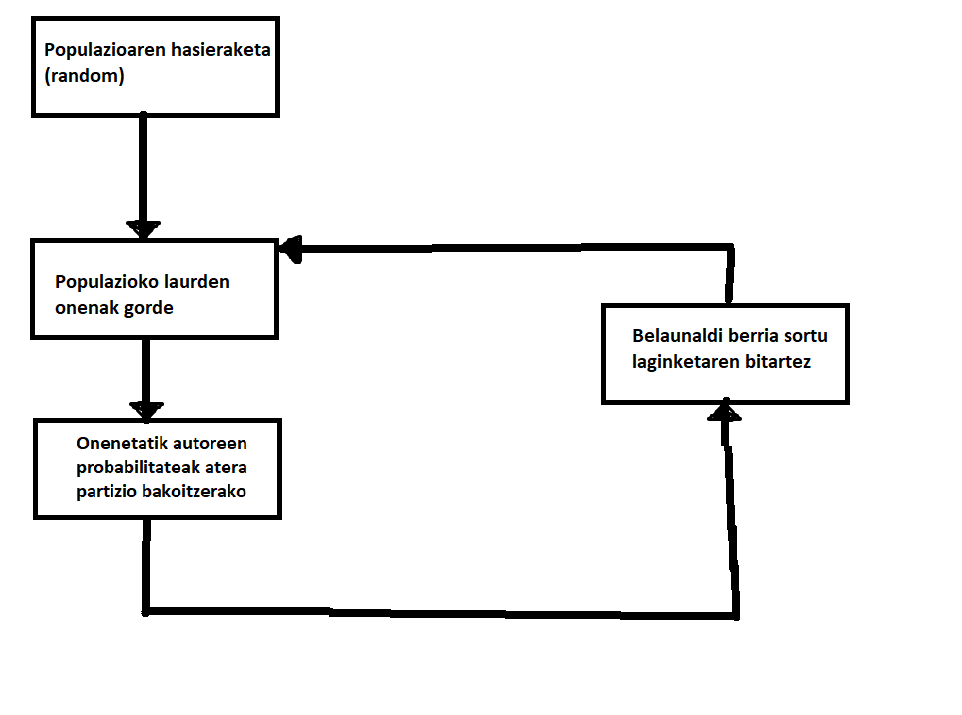

In [63]:
import time
def EDA_Hasieraraketa(G,pop_tam,part_kop):
    #EDA algoritmoaren hasieraketa funtzioa
    #pop_tam tamainako ausazko populazioa bueltatzen du
    pop = list()
    for i in range(pop_tam):
        pop.append(randomSol(G, part_kop, part_kop)) #Ausazko soluzioa sortu
    return pop

def EDA_ProbabilitateakLortu(populazioa, part_kop, authors):
    #EDA algorimoaren probabilitate funtzioaren kalkulua
    #Autore bakoitzarentzat partizio bakoitzean egoteko probabilitatea bueltatzen du.
    populazioa = list(map(part_to_dict, populazioa))
    prob_list = [np.zeros(len(populazioa[0])) for i in range(part_kop)]
    for i in populazioa:
        for j in i:
            prob_list[i[j]][np.where(authors == j)] += 1 /len(populazioa)
    prob_list = np.array(prob_list)
    return prob_list 


def EDA_HurrengoSoluzioakSortu(prob_list, tamaina, part_kop, authors):
    #EDA algoritmoaren belaunaldi berriaren kalkulua
    #Autore bakoitzarentzako, partizioen probabilitate funtzioa(prob_list) lagintzen du tamaina aldiz
    #Prob_list funtzioak jarraituz, tamaina soluzio berri bueltatzen ditu
    l = [np.random.choice(part_kop,tamaina, p = prob_list[:, i]) for i in range(len(prob_list[0]))]
    l = np.transpose(np.array(l))
   # time3 = time.process_time()
    res2 = list(map(lambda x: dict_to_part(dict(zip(authors, x)), part_kop -1), l))
    #time4 = time.process_time()
    return res2

def EDA_OnenakAukeratu(G, pop, tamaina, num_parts):
    #EDA algoritmoaren aukeraketa funtzioa
    #Populazioa(pop) bat emanda populaziotik(pop) tamaina onenak bueltatzen ditu
    pop_berri = sorted(pop, key=lambda x : modularitatea(G, x, num_parts), reverse=True)
    pop_berri = pop_berri[0:int(tamaina)]
    return pop_berri, len(pop)

def EDA(G,populazio_tamaina, zatiOnenak, part_kop, maximo_ebaluazio):
    #EDA algoritmoaren inplementazioa
    time1 = time.process_time()
    x = []
    y = []
    authors = np.array(G.nodes())
    authors_dict = dict(zip(authors,([0 for j in range(part_kop)] for i in range(len(authors)))))
    pop = EDA_Hasieraraketa(G,populazio_tamaina,part_kop)
    ebaluazio_kop_act = 0
    while ebaluazio_kop_act < maximo_ebaluazio:
        onenak, lag = EDA_OnenakAukeratu(G, pop, populazio_tamaina/zatiOnenak, part_kop)
        ebaluazio_kop_act += lag
        x.append(ebaluazio_kop_act)
        y.append(modularitatea(G, onenak[0]))
        if ebaluazio_kop_act >= maximo_ebaluazio:
            break
        prob_list = EDA_ProbabilitateakLortu(onenak, part_kop, authors)
        
        pop = EDA_HurrengoSoluzioakSortu(prob_list, populazio_tamaina, part_kop, authors)
    print("ebaluazioak, ", ebaluazio_kop_act)
    #plt.plot(x, y)
    time2  =time.process_time()
    return modularitatea(G, onenak[0]), time2 - time1

G = generator(1000)
time1 = time.time()
#mod, onenak = EDA(G, 200, 100,4, 5)
time2 = time.time()
print(time2 - time1)

6.937980651855469e-05


In [10]:
l = EDA_ProbabilitateakLortu(onenak, part_kop, authors)
print(len(l))

In [140]:
import pandas as pd
num_generator = 5
edaRes = []
simulated_res = []


In [91]:
def createCSV(erantzuna, izenakx,izenaky, csvN):
    df = pd.DataFrame(erantzuna, izenaky, columns=izenakx)
    os.makedirs('CSV/', exist_ok=True)  
    df.to_csv('CSV/' + csvN)
#createCSV(erantzuna, izenak,list(range(int(len(erantzuna)))), "era")

In [167]:
#Parameter tunning
part_kop = 4
iterazioKop = 5000
edaParams = {"populazio_tamaina": [25, 50, 75], "zatiOnena": [4,5,6]}
#simulatedParams = {"beta": [0.05, 0.1,0.2, 0.3, 0.4,0.5, 0.7], "p": [0.5, 0.6, 0.7, 0.8, 0.85]}
#simulatedParams = {"beta": [0.05, 0.1], "p": [0.5, 0.6]}

resEDA = np.zeros((len(edaParams["populazio_tamaina"]),len(edaParams["zatiOnena"])))
n = 5
#G = generator(2000)
for idx, i in enumerate(edaParams["populazio_tamaina"]):
    for idj, j in enumerate(edaParams["zatiOnena"]):
        print(i, j)
        m = 0
        for k in range(n):
            a =EDA (G, 100000000000, i, j, part_kop, iterazioKop)
            m += a[0]
        resEDA[idx][idj] = m / n
createCSV(resEDA, edaParams["zatiOnena"], edaParams["populazio_tamaina"], "EDAParameterONA2")

"""
resSIM = np.zeros((len(simulatedParams["beta"]), len(simulatedParams["p"])))

for idx, i in enumerate(simulatedParams["beta"]):
    for idj, j in enumerate(simulatedParams["p"]):
        m = 0
        for k in range(n):
            a =simulated_annealing(G,part_kop, iterazioKop,i, p = j)
            m += a[0]
        resSIM[idx][idj] = m / n

createCSV(resSIM, simulatedParams["p"], simulatedParams["beta"], "SIMParameterONA")
"""


25 4
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
25 5
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
25 6
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
50 4
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
50 5
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
50 6
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
ebaluazioak,  5000
75 4
ebaluazioak,  5025
ebaluazioak,  5025
ebaluazioak,  5025
ebaluazioak,  5025
ebaluazioak,  5025
75 5
ebaluazioak,  5025
ebaluazioak,  5025
ebaluazioak,  5025
ebaluazioak,  5025
ebaluazioak,  5025
75 6
ebaluazioak,  5025
ebaluazioak,  5025
ebaluazioak,  5025
ebaluazioak,  5025
ebaluazioak,  5025


'\nresSIM = np.zeros((len(simulatedParams["beta"]), len(simulatedParams["p"])))\n\nfor idx, i in enumerate(simulatedParams["beta"]):\n    for idj, j in enumerate(simulatedParams["p"]):\n        m = 0\n        for k in range(n):\n            a =simulated_annealing(G,part_kop, iterazioKop,i, p = j)\n            m += a[0]\n        resSIM[idx][idj] = m / n\n\ncreateCSV(resSIM, simulatedParams["p"], simulatedParams["beta"], "SIMParameterONA")\n'

In [ ]:

x_min = optimize.minimize(sixhump, x0=[0, 0])

plt.figure()
# Show the function in 2D
plt.imshow(sixhump([xg, yg]), extent=[-2, 2, -1, 1], origin="lower")
plt.colorbar()
# And the minimum that we've found:
plt.scatter(x_min.x[0], x_min.x[1])

plt.show()


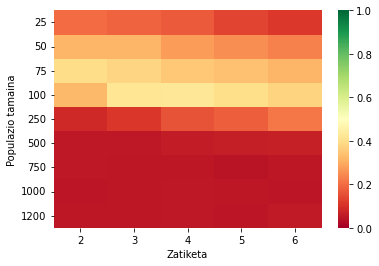

In [258]:
import matplotlib.pyplot as plt
import seaborn as sns
def parameterGraph(M):
    fig, ax = plt.subplots(1,1)
    Cols = [2, 3, 4, 5, 6]
    Index = [25, 50,75,100,250,500,750,1000,1200]
    
    test_df = pd.DataFrame(M,index=Index, columns=Cols)
    s  =sns.heatmap(test_df,cmap=plt.cm.RdYlGn,vmin=0,vmax=1)
    s.set(xlabel='Zatiketa', ylabel='Populazio tamaina')
    
parameterGraph(M)
#Parametro onenak
#eda = EDA (G, 100000000000, 100, 4, part_kop, iterazioKop)


In [168]:
M = [[0.1991905699, 0.1870734806,0.1683847004,0.1366750998,0.1143458331],
    [0.3142507824, 0.3126254755, 0.2756621503,0.2538111355,0.2334242612],
    [0.3959258635, 0.382507974, 0.3531559753, 0.3373132438, 0.3130383614],
    [0.3218065628,0.4192458912,0.4237140234,0.4021654017,0.3751820993],
    [0.08360075711,0.1108632897,0.1562867263,0.1795230224,0.215361931],
    [0.05099514627,0.05087438391,0.06102037068,0.06565626581,0.07028796312],
    [0.0544196698,0.05007754727,0.04926017129,0.04162148386,0.04771274901],
    [0.04434632035,0.04925792245,0.05265351099,0.04813507993,0.04497359495],
    [0.04699732014,0.04896092652,0.05092288375,0.04681658889,0.05502850396]]

In [ ]:
#Esperimentazioa
#mod, onenak = EDA(G, 4, 500, part_kop, iterazioKop)
#simulated_annealing(G, 5, 1000, 0.1)
part_kop = 4
iterazioKop = 5000
def EDA(G,populazio_tamaina, zatiOnenak, part_kop, maximo_ebaluazio):
#simulated_annealing(G,part_kop, iter_kop,beta, p = 0.75):


/tmp/ipykernel_4315/2989255478.py:45: RuntimeWarning: overflow encountered in exp
  accept = exp(-dif*100 / t)


temps
evals


(0.71015048831924, 275.8046588359998)

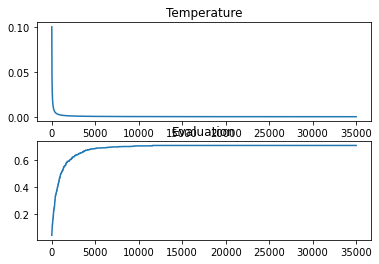

In [77]:
G =  generator(2000)
part_kop = 4
iterazioKop = 35000
simulated_annealing(G,part_kop, iterazioKop,0.5, p = 0.5)

ebaluazioak,  50000


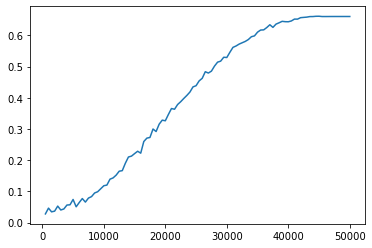

In [102]:
mod, times= EDA(G, 500, 4, 4, 50000)

In [103]:
mod

0.6601883663315657

In [100]:
def evaluations():
    evaluations = [1000, 5000, 10000, 20000, 30000, 40000]
    #evaluations = [100, 200]
    repetitions1 = []
    repetitions_time1 = []
    repetitions2 = []
    repetitions_time2 = []
    samples =15
    samplesID = [i for _ in range(len(evaluations)) for i in range(samples)]
    print(samplesID)
    y_ID = ["eda", "time", "simulated", "time"]
    print(y_ID)
    for i in evaluations:
        for j in range(samples):
            G = generator(2000)
            mod, time = mod, times= EDA(G, 500, 4, 4, i)
            repetitions1.append(mod)
            repetitions_time1.append(time)
            mod, times= simulated_annealing(G,part_kop, i,0.5, p = 0.5)
            repetitions2.append(mod)
            repetitions_time2.append(time)
    erantzuna = [repetitions1, repetitions_time1, repetitions2, repetitions_time2]
    createCSV(erantzuna, samplesID, y_ID,"ScalabilityAttenttion")

In [101]:
evaluations()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
['eda', 'time', 'simulated', 'time']


KeyboardInterrupt: 